In [1]:
import pandas as pd
import numpy as np
import re

#Defining what dtype to convert each column to
#numberic columns are transformed after reading in
dtype_dict = {'Product':"category",
             'Consumer consent provided?': "category",
             'Submitted via': "category",
             'Copany response to consumer': "category",
             'Consumer disputed?': "category"}

#read in .csv file, dates are parsed into datetime objects. 
#The Complaint ID is Unique in every entry, so it can be used as index
df = pd.read_csv('Consumer_Complaints.csv',
                 index_col=['Complaint ID'],
                 parse_dates=["Date received","Date sent to company"],
                 dtype=dtype_dict)

df.head()

C:\Users\alexr\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\alexr\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?
Complaint ID,,,,,,,,,,,,,,,,,
3403230,2019-10-12,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,NaN,NaN,"Avantus, LLC",MS,39648,NaN,NaN,Web,2019-10-12,In progress,Yes,NaN
3402299,2019-10-11,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,NaN,Company believes the complaint is the result o...,Millco Management,TX,76542,Servicemember,Consent not provided,Web,2019-10-11,Closed with explanation,Yes,NaN
3402857,2019-10-11,Debt collection,Medical debt,Attempts to collect debt not owed,Debt was result of identity theft,NaN,NaN,"Commonwealth Financial Systems, Inc.",TX,770XX,NaN,NaN,Web,2019-10-11,Closed with explanation,Yes,NaN
3403510,2019-10-11,Debt collection,Federal student loan debt,Attempts to collect debt not owed,Debt is not yours,NaN,Company has responded to the consumer and the ...,"Ability Recovery Services, LLC",FL,32177,NaN,Consent not provided,Web,2019-10-11,Closed with explanation,Yes,NaN
3403477,2019-10-11,Credit card or prepaid card,General-purpose credit card or charge card,Problem when making payments,You never received your bill or did not know a...,NaN,NaN,NAVY FEDERAL CREDIT UNION,FL,335XX,Servicemember,NaN,Web,2019-10-11,In progress,Yes,NaN


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1405841 entries, 3403230 to 2259
Data columns (total 17 columns):
Date received                   1405841 non-null datetime64[ns]
Product                         1405841 non-null category
Sub-product                     1170675 non-null object
Issue                           1405841 non-null object
Sub-issue                       859157 non-null object
Consumer complaint narrative    449916 non-null object
Company public response         513899 non-null object
Company                         1405841 non-null object
State                           1382920 non-null object
ZIP code                        1276957 non-null object
Tags                            191911 non-null object
Consumer consent provided?      805116 non-null category
Submitted via                   1405841 non-null category
Date sent to company            1405841 non-null datetime64[ns]
Company response to consumer    1405840 non-null object
Timely response?           

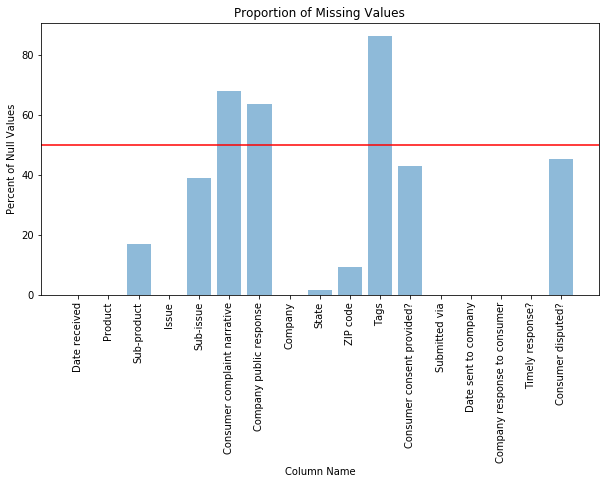

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

colList = df.columns.tolist()
y_pos = np.arange(len(colList))
percentMissing = (1 - df.count().values/len(df)) * 100

plt.figure(figsize=(10,5))
plt.bar(y_pos, percentMissing, align='center', alpha=0.5)
plt.axhline(y=50, color='r', linestyle='-')

plt.xlabel('Column Name')
plt.xticks(y_pos, colList, rotation='vertical')
plt.ylabel('Percent of Null Values')
plt.title('Proportion of Missing Values')

plt.show()

Starting off this investigation, this graph above show the percentage of values missing for each columns, and a red line has been drawn to show where the 50% cut off is. Since the columns "Consumer complaint narrative", "Company public response" and "Tags" are missing for more than half of the entries, they will not be used in the machine learning model. For "Consumer complaint narrative", a new column with be made referring to whether or not the column in empty instead, as this may have predictive value. Also, since the goal of this project is to determine how a complaint will be resolved, the consumer disputing is not recorded until after the complaint has been resolved, so it also will not be used in the model. Since the information provided by State and ZIP code are redundant, with the ZIP code being more descriptive, the state column will be ommited from the model.

Also note that since the Complaint ID is unique for each row, it has been chosen to be the index for the dataframe.

Date received  has  2872 unique values
Product  has  18 unique values
Sub-product  has  77 unique values
Issue  has  166 unique values
Sub-issue  has  219 unique values
Consumer complaint narrative  has  428302 unique values
Company public response  has  11 unique values
Company  has  5428 unique values
State  has  64 unique values
ZIP code  has  23256 unique values
Tags  has  4 unique values
Consumer consent provided?  has  5 unique values
Submitted via  has  6 unique values
Date sent to company  has  2821 unique values
Company response to consumer  has  9 unique values
Timely response?  has  2 unique values
Consumer disputed?  has  3 unique values


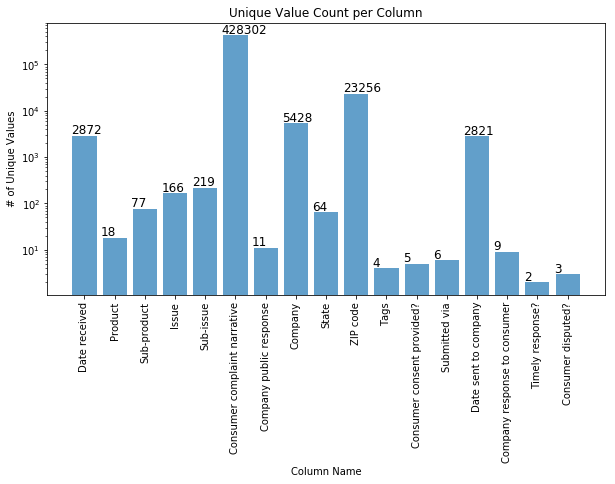

In [4]:
uniqueCountList = []
for column in df.columns:
    uniqueCount = len(df[column].unique())
    uniqueCountList.append(uniqueCount)
    print(column, " has ", uniqueCount, "unique values")

y_pos = np.arange(len(df.columns))
plt.figure(figsize = (10, 5))
plt.bar(y_pos, uniqueCountList, align='center', alpha=0.7, log=True)

plt.xlabel('Column Name')
plt.xticks(y_pos, df.columns, rotation='vertical')
plt.ylabel('# of Unique Values')
plt.title('Unique Value Count per Column')

for i in y_pos:
    plt.text(x = i - 0.45, 
             y = uniqueCountList[i] * 1.1, 
             s = str(uniqueCountList[i]), 
             size = 12)

plt.show()

To conserve memory, as well as allow One-Hot encoding later, it would be beneficial to change many of the object dtype objects to categorical, or to a float for the case of "ZIP code". One-Hot-Encoding is a bit excessive if applied to a column with way above 20-25 categories, so only the top 23 most common categories for each column will be identified while the remaining will be casted to an "Other" category. Since "Timely response?" has only 2 unique values, it is to be turned to a 0-1 encoding as only one column.

Below, there is the code that trasforms the "ZIP code" and "Timely response?" columns. Under that is a pair of functions to reduce the number of categories was defined.

After investigating the "ZIP code" column, there are values with all 5 digits, some with the first 3 followed by two X's, and then some that have dashes inplace of digits. For the entrie with X's, they will be replaced with 50, values ending in a dash will replaced with a 5, and all other strage entries that are non-5-digit entries will be changed to NaN. Lastly, the NaN values will be imputed to the average ZIP code.

In [5]:
#This will replace ending '-' to 5 (average linespace of 10)
regexReplaceDash = r"(\d+)(-)$"
df['ZIP code'] = df['ZIP code'].str.replace(regexReplaceDash, r'\g<1>5')

#This will change ending XX to 50 (average linespace of 100)
regex_XX = r'(\d{3})(XX)'
df['ZIP code'] = df['ZIP code'].str.replace(regex_XX, r'\g<1>50')

#This will remove all other entries that are still not 5 digits
regexRemove = r'\D+'
df['ZIP code'] = df['ZIP code'].replace(regexRemove, np.nan, regex=True)


In [6]:
#This Checks that all remaining values either 5 digits or NaN
regexNorm = r'\d{5}'
df[~df['ZIP code'].str.contains(regexNorm).fillna(True)]['ZIP code']

Series([], Name: ZIP code, dtype: object)

In [7]:
imputeMean = df['ZIP code'].astype(np.float).mean()
df['ZIP code'] = df['ZIP code'].astype(np.float).fillna(imputeMean)

Now that the "ZIP code" column in a form that can be processed for ML algorithms, lets move on to adjusting the "Timely Response?" column. This one is simpler, only requires mapping and recasting the type

In [8]:
#Transforming 2 unique valued col to float boolean
booleanize = {'Yes': 1, 'No': 0}
df['Timely response?'] = pd.Series(df['Timely response?'].map(booleanize), dtype = np.float)

For the rest of the columns that involves strings but have "too many" catgories, all categories that aren't featured in the top 23 most common categories will be truncated to a single "Other" category. Each Column's most common categores will be checked to make sure there aren't somes that are worth including in "Other", for example, categores that include the word "Other" or are uninformative like "I do not know". NaN's are also to be converted to "Other".

First we define some functions to do this task repeatatively for each column, as well as cast the data to categorical dtype.

In [9]:
#function to apply to column to convert less common results to 'Other', as well as NaN
def convertToOther(value, keepList):
    if (value == ''):
        return "Other"
    else:
        return value if value in keepList else "Other"

In [10]:
#Lists top 23 value counts (allowed to exclude values), turns NaN to '' to others, converts to category dtype
def cleanReduceConvert(df, column, blackList=[]):
    keepList = []
    for category in df[column].value_counts().head(23).index.tolist():
        if (category.lower().split()[0] != "other"):
            keepList.append(category)
    for category in blackList:
        try:
            keepList.remove(category)
        except ValueError:
            pass

    df[column].fillna('', inplace=True)
    return pd.Series(df[column].apply(convertToOther, args=(keepList,)), dtype = 'category')

In [11]:
#Creates bar graph of proportion of each category given the column
def graphCategoryPercents(df, column):
    y = df[column].value_counts().values/len(df)*100
    x = df[column].value_counts().index
    x_pos = np.arange(len(x))

    plt.figure(figsize = (10, 5))
    plt.bar(x_pos, y, align='center', alpha=0.7)

    plt.xlabel('Category')
    plt.xticks(x_pos, x, rotation='vertical')
    plt.ylabel('% of Rows with this Category')
    plt.title('Proportion per Category in {}'.format(column))
    plt.show()

In [12]:
df['Sub-product'].value_counts()[0:23]

Credit reporting                              283182
Checking account                               96946
Other mortgage                                 86635
Conventional fixed mortgage                    70613
I do not know                                  54538
General-purpose credit card or charge card     45546
Other (i.e. phone, health club, etc.)          44544
Other debt                                     36080
Conventional home mortgage                     35027
FHA mortgage                                   33098
Credit card                                    28698
Conventional adjustable mortgage (ARM)         25380
Non-federal student loan                       25164
Credit card debt                               25135
Federal student loan servicing                 24282
Medical                                        21187
Medical debt                                   19441
Other bank product/service                     17825
Vehicle loan                                  

In [13]:
#'I do not know' will be converted to Other
df['Sub-product'] = cleanReduceConvert(df, 'Sub-product', blackList= ['I do not know'])

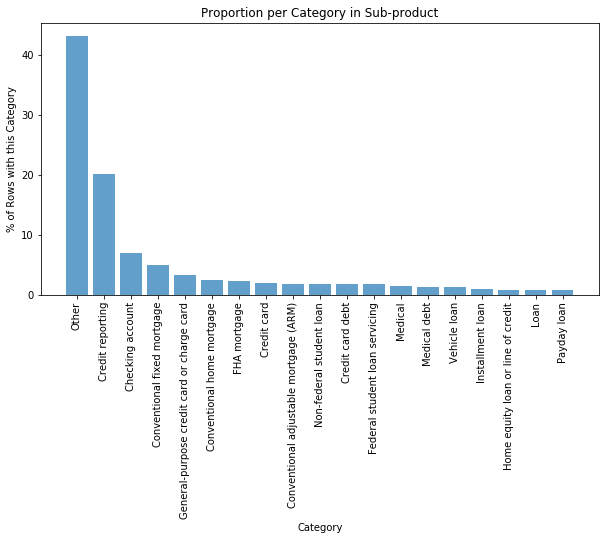

In [14]:
graphCategoryPercents(df,'Sub-product')

In [15]:
df['Issue'].value_counts()[0:23]

Incorrect information on your report                                                175511
Loan modification,collection,foreclosure                                            112310
Incorrect information on credit report                                              102686
Loan servicing, payments, escrow account                                             77333
Problem with a credit reporting company's investigation into an existing problem     65225
Cont'd attempts collect debt not owed                                                60683
Attempts to collect debt not owed                                                    53064
Improper use of your report                                                          39031
Account opening, closing, or management                                              37961
Communication tactics                                                                37594
Managing an account                                                                  31688

In [16]:
df['Issue'] = cleanReduceConvert(df, 'Issue')

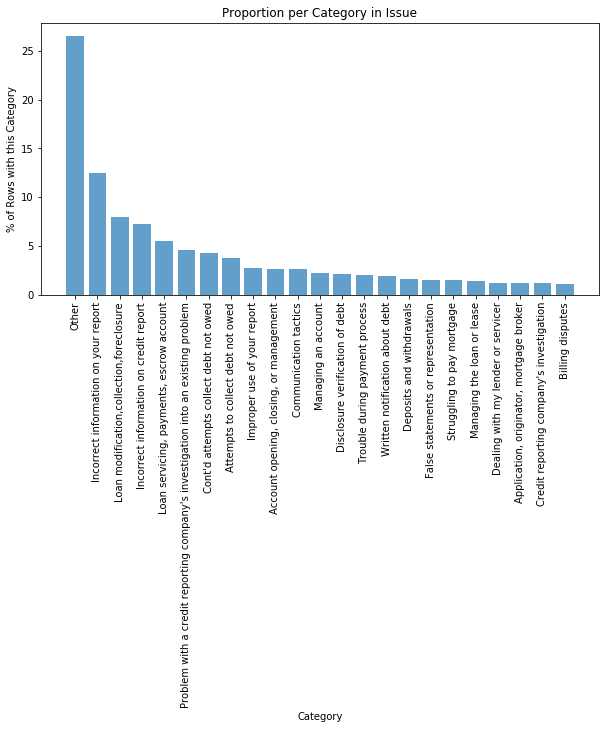

In [17]:
graphCategoryPercents(df,'Issue')

In [18]:
df['Sub-issue'].value_counts()[0:23]

Information belongs to someone else                                                 85048
Their investigation did not fix an error on your report                             47467
Account status                                                                      37057
Debt is not mine                                                                    36728
Information is not mine                                                             32384
Account status incorrect                                                            32307
Account information incorrect                                                       28667
Debt is not yours                                                                   27988
Debt was paid                                                                       27898
Credit inquiries on your report that you don't recognize                            25807
Frequent or repeated calls                                                          21969
Not given 

In [19]:
df['Sub-issue'] = cleanReduceConvert(df, 'Sub-issue')

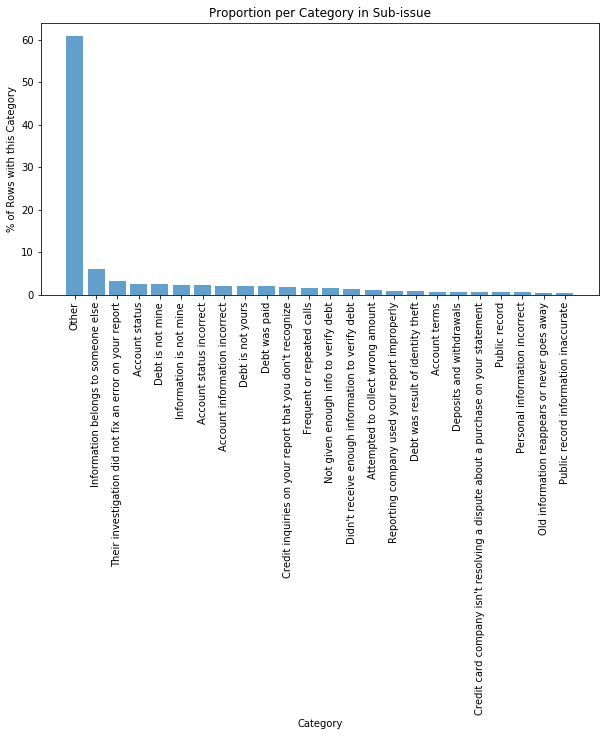

In [20]:
graphCategoryPercents(df,'Sub-issue')

In [21]:
df['Company'].value_counts()[0:23]

EQUIFAX, INC.                             134263
Experian Information Solutions Inc.       119608
TRANSUNION INTERMEDIATE HOLDINGS, INC.    115108
BANK OF AMERICA, NATIONAL ASSOCIATION      85711
WELLS FARGO & COMPANY                      74213
JPMORGAN CHASE & CO.                       63912
CITIBANK, N.A.                             52077
CAPITAL ONE FINANCIAL CORPORATION          37888
Navient Solutions, LLC.                    30739
OCWEN FINANCIAL CORPORATION                28520
SYNCHRONY FINANCIAL                        23980
NATIONSTAR MORTGAGE                        21226
U.S. BANCORP                               18238
AMERICAN EXPRESS COMPANY                   14946
Ditech Financial LLC                       14507
PNC Bank N.A.                              12459
ENCORE CAPITAL GROUP INC.                  12138
PORTFOLIO RECOVERY ASSOCIATES INC          11355
DISCOVER BANK                              11264
TD BANK US HOLDING COMPANY                 10573
AES/PHEAA           

In [22]:
df['Company'] = cleanReduceConvert(df, 'Company')

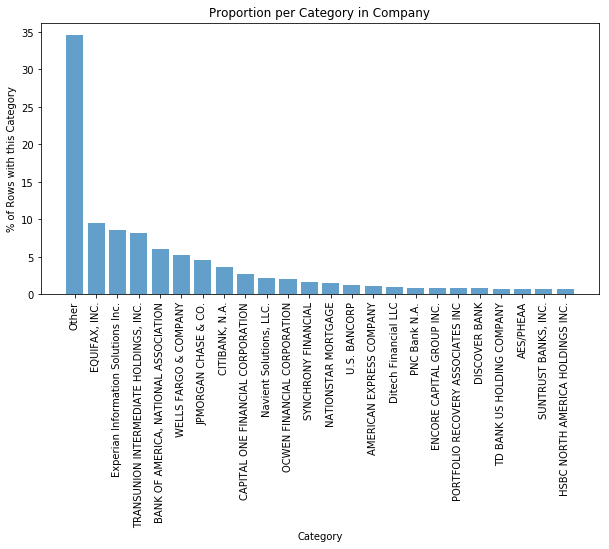

In [23]:
graphCategoryPercents(df,'Company')

It should be noted that truncating the less common categories always resulted with "Other" being the most common category. This is particularly bad in 'Sub-issue' where more than half of the data is now categorized as an "Other" sub-issue.

To not completely through away the influence of the "Consumer complaint narrative", a new column will be made on weather or not a Consumer Narrative was submitted.

In [24]:
def entryOrNull(strVal):
    return 1.0 if strVal is not np.nan else 0.0

df['Consumer complaint narrative submitted?'] = df['Consumer complaint narrative'].apply(entryOrNull)

The date Columns need to be seperated into seperate seperate columns that are integers. A quick function will be defined too do this and then applied to the two date columns.

In [25]:
def dtToCols(df, dtcolumn):
    df["{} day".format(dtcolumn)] = df[dtcolumn].dt.day
    df["{} month".format(dtcolumn)] = df[dtcolumn].dt.month
    df["{} year".format(dtcolumn)] = df[dtcolumn].dt.year

In [26]:
dtToCols(df, "Date received")
dtToCols(df, "Date sent to company")

Lastly the Null values in "Consumer consented provided?" will be imputed with the value "Not recorded".

In [27]:
df["Consumer consent provided?"] = df["Consumer consent provided?"].cat.add_categories("Not recorded").fillna("Not recorded")

Now lets make sure that all the columns that will be used for ML are free of any Null values.

In [28]:
for column in df.columns:
    print('"',column, '" has no null values: ', df[column].notna().all())

" Date received " has no null values:  True
" Product " has no null values:  True
" Sub-product " has no null values:  True
" Issue " has no null values:  True
" Sub-issue " has no null values:  True
" Consumer complaint narrative " has no null values:  False
" Company public response " has no null values:  False
" Company " has no null values:  True
" State " has no null values:  False
" ZIP code " has no null values:  True
" Tags " has no null values:  False
" Consumer consent provided? " has no null values:  True
" Submitted via " has no null values:  True
" Date sent to company " has no null values:  True
" Company response to consumer " has no null values:  False
" Timely response? " has no null values:  True
" Consumer disputed? " has no null values:  False
" Consumer complaint narrative submitted? " has no null values:  True
" Date received day " has no null values:  True
" Date received month " has no null values:  True
" Date received year " has no null values:  True
" Date se

Looks like our target column has some null values. See the rows that have NaN in that column.

In [29]:
df[df["Company response to consumer"].isna()]

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,...,Company response to consumer,Timely response?,Consumer disputed?,Consumer complaint narrative submitted?,Date received day,Date received month,Date received year,Date sent to company day,Date sent to company month,Date sent to company year
Complaint ID,,,,,,,,,,,,,,,,,,,,,
2770980,2018-01-03,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Old information reappears or never goes away,I called the phone number as listed on the cre...,NaN,"EQUIFAX, INC.",CA,94550.0,...,NaN,1.0,NaN,1.0,3,1,2018,3,1,2018


There's only 1 entry with a null value there, so it'll be drop since this won't cost much to lose one row.

In [30]:
df = df.drop(df[df["Company response to consumer"].isna()].index)

The last thing to clean up is transforming the target to be ready for predicting. This will be done by first spliting the data frame into a dataframe that have complaints that are still "in progress" which we can try predicting later, and a dataframe with resolved complaints to train on. Quickly before that, let's take a look at the distribution of responses.

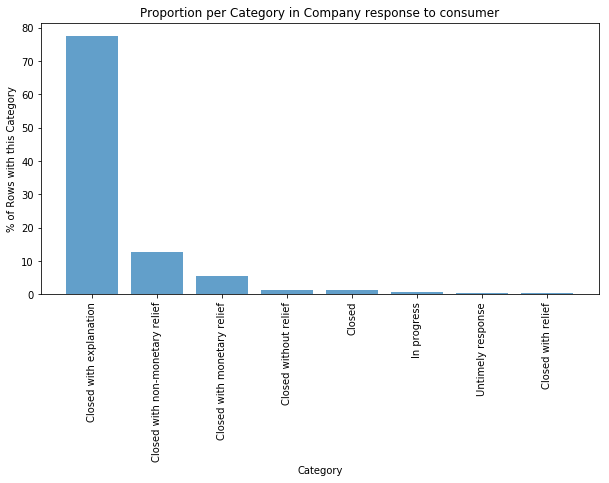

Closed with explanation            1091858
Closed with non-monetary relief     177799
Closed with monetary relief          79159
Closed without relief                17868
Closed                               17611
In progress                           9433
Untimely response                     6808
Closed with relief                    5304
Name: Company response to consumer, dtype: int64

In [31]:
graphCategoryPercents(df, "Company response to consumer")
df["Company response to consumer"].value_counts()

It looks like there's not too many "In progress" entries. So we're not losing much of the data when we seperate these columns. We'll also remove the untimely responses, since their conclusions are not really specified.

In [32]:
dfInProgress = df[df["Company response to consumer"] == "In progress"]
df = df[df["Company response to consumer"] != "In progress"]

In [33]:
dfUntimelyResponse = df[df["Company response to consumer"] == "Untimely response"]
df = df[df["Company response to consumer"] != "Untimely response"]

Next up, the target column is going to be truncated to 2 categories according to the dict declared below.

In [34]:
twoOutputsDict = {"Closed with explanation":"Closed without relief", 
                  "Closed with non-monetary relief":"Closed with relief",
                  "Closed with monetary relief":"Closed with relief",
                  "Closed without relief":"Closed without relief", 
                  "Closed":"Closed without relief",
                  "Closed with relief":"Closed with relief"}
df["Company response to consumer"] = df["Company response to consumer"].map(twoOutputsDict)

Proceeding from here, the features to be used will be placed into one data frame, and the target into another dataframe, labeled simply 'X' and 'Y'. Then the train test split will be made with 20% of the data withheld for testing/

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1389599 entries, 3402299 to 2259
Data columns (total 24 columns):
Date received                              1389599 non-null datetime64[ns]
Product                                    1389599 non-null category
Sub-product                                1389599 non-null category
Issue                                      1389599 non-null category
Sub-issue                                  1389599 non-null category
Consumer complaint narrative               446965 non-null object
Company public response                    513899 non-null object
Company                                    1389599 non-null category
State                                      1367043 non-null object
ZIP code                                   1389599 non-null float64
Tags                                       189714 non-null object
Consumer consent provided?                 1389599 non-null category
Submitted via                              1389599 non-null ca

After doing the training test split, Standard Scaler and One Hot Encoding will be fit on the numeric and categorical data, respectively, and then applied to transfrom the training and testing data. 

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

#data columns not be used for the model
dropList = ["Consumer complaint narrative",
            "Company public response",
            "State",
            "Tags",
            "Consumer disputed?",
            "Date received", 
            "Date sent to company",
            "Company response to consumer"]
X = df.drop(dropList, axis=1)
Y = df["Company response to consumer"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

#Columns to be standard scaled/imputed
numeric_features = ['ZIP code',
                    'Date received day',
                    'Date received month',
                    'Date received year',
                    'Date sent to company day',
                    'Date sent to company month',
                    'Date sent to company year']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

#Columns to one hot encoded
categorical_features = ['Product',
           'Sub-product',
           'Issue',
           'Sub-issue',
           'Company',
           'Consumer consent provided?',
           'Submitted via',
           'Timely response?']
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

#building the column transformer with both transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

#fit the preprocessor, then transform trainging and test set, assign sparse matrix to variables
preprocessor.fit(X)
encX_train = preprocessor.transform(X_train)
encX_test = preprocessor.transform(X_test)

Since there are multiple transformers wrapped in the ColumnTransformer, this function below provided by pjgao creates a list of the columns. This is useful for feature importances after running the Model Trainging. Heres a link to where the code was found: https://github.com/scikit-learn/scikit-learn/issues/12525#issuecomment-436217100

In [37]:
def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_[:-1]:#the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name

processedColumns = get_column_names_from_ColumnTransformer(preprocessor)

The first model to be run on this will be RandomForrestClassifier from sklearn's library. A grid search is used to find the better tuning of the hyper parameters.

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

#define classifier and parameter grid
rf = RandomForestClassifier()
forest_para = {'criterion':['gini','entropy'],
                'min_samples_split' : range(2,6,2),
                'max_depth': range(3,7,2),
                'n_estimators':range(10,30,10)}


#Grid search to find best hyper parameters
fitmodel = GridSearchCV(rf,forest_para,cv=3, scoring='roc_auc')
fitmodel.fit(encX_train,y_train)

#store the best fitting model, create prediciton from X_test data
bestfitRF = fitmodel.best_estimator_

#fit once more on the best estimator
bestfitRF.fit(encX_train,y_train)
y_pred = bestfitRF.predict(encX_test)
print(bestfitRF.score(encX_test,y_test))

#display the result
print(classification_report(y_test, y_pred))

0.8117695739781232


C:\Users\alexr\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                       precision    recall  f1-score   support

   Closed with relief       0.00      0.00      0.00     52313
Closed without relief       0.81      1.00      0.90    225607

            micro avg       0.81      0.81      0.81    277920
            macro avg       0.41      0.50      0.45    277920
         weighted avg       0.66      0.81      0.73    277920



It seems that the random forrest couldn't make any prediction with this dataset, as it went the lazy underfitting route of gussing every label to be the majority class. This is likely due to the One Hot Encoding with too many categories. Since the tree makes a few set of decisions, and the max depth goes to 7, there's not much predictive power in only using 7 columns in a row that are all 0 (for example).

Next, the data will be run through a LogisticRegression Model. Note that 'l1' penalty was used because that penalty usually zeros out less important coefficients, which since this was one hot encoded, is expected to happen a lot.

In [39]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(n_jobs=-1, solver='saga', penalty='l1')
lr_para = {'C':[1.0,0.1,0.01], 
           'class_weight':[None,'balanced'],
           'max_iter':[50,100,150]}

#Apply grid search with above parameters specified
fitmodel = GridSearchCV(lr, lr_para,cv=5, scoring='roc_auc', n_jobs=-1)
fitmodel.fit(encX_train,y_train)

#store the best fitting DecisionTreeClassifier(), create prediciton from X_test data
bestfitLR = fitmodel.best_estimator_

bestfitLR.fit(encX_train,y_train)
y_pred = bestfitLR.predict(encX_test)
print(bestfitLR.score(encX_test,y_test))

#display the result
print(classification_report(y_test, y_pred))

C:\Users\alexr\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.6762305699481865
                       precision    recall  f1-score   support

   Closed with relief       0.32      0.66      0.43     52313
Closed without relief       0.90      0.68      0.77    225607

            micro avg       0.68      0.68      0.68    277920
            macro avg       0.61      0.67      0.60    277920
         weighted avg       0.79      0.68      0.71    277920



Although the score was low for this, looking at precision, recall, and f1, it seems like a improvement from guessing the majority class everytime.

In [40]:
print(bestfitLR)

coef_df = pd.DataFrame([processedColumns,list(bestfitLR.coef_[0])]).transpose().sort_values(1)
coef_df.iloc[np.r_[0:10, -10:0]]

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=150,
          multi_class='warn', n_jobs=-1, penalty='l1', random_state=None,
          solver='saga', tol=0.0001, verbose=0, warm_start=False)

Next the a gradient boosted tree classifier will be trained.

In [41]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()
gbc_para = {'loss':['deviance', 'exponential'],
            'learning_rate': [0.1, 0.05],
            'max_depth': [3,7]}

#Apply grid search with above parameters specified
fitmodel = GridSearchCV(gbc, gbc_para,cv=3, scoring='roc_auc', n_jobs=-1)
fitmodel.fit(encX_train,y_train)

#store the best fitting DecisionTreeClassifier(), create prediciton from X_test data
bestfitGBC = fitmodel.best_estimator_

bestfitGBC.fit(encX_train,y_train)
y_pred = bestfitGBC.predict(encX_test)
print(bestfitGBC.score(encX_test,y_test))

#display the result
print(classification_report(y_test, y_pred))

0.8204555267702937
                       precision    recall  f1-score   support

   Closed with relief       0.64      0.11      0.18     52313
Closed without relief       0.83      0.99      0.90    225607

            micro avg       0.82      0.82      0.82    277920
            macro avg       0.73      0.55      0.54    277920
         weighted avg       0.79      0.82      0.76    277920



In [ ]:
print(bestfitGBC)

coef_df = pd.DataFrame([processedColumns,list(bestfitGBC.feature_importances_)]).transpose().sort_values(1, ascending=False)
coef_df.iloc[np.r_[0:10, -10:0]]

Since there was an imbalance of classes, I've resample by downsampling the majority class to create a 1:1 ratio between the classes, to see if this improves predicting power.

In [42]:
from sklearn.utils import resample

df_resample = pd.concat([X_train, y_train],axis=1)
not_relief = df_resample[df_resample['Company response to consumer']=='Closed without relief']
relief = df_resample[df_resample['Company response to consumer']=='Closed with relief']

not_relief_downsample = resample(not_relief,
                                 replace=False,
                                 n_samples = len(relief))

downsample = pd.concat([not_relief_downsample, relief])

X_train = df.drop(dropList, axis=1)
y_train = df["Company response to consumer"]

#fit the preprocessor, then transform trainging and test set, assign sparse matrix to variables
encX_train = preprocessor.transform(X_train)
encX_test = preprocessor.transform(X_test)

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

lr = LogisticRegression(penalty='l1')
lr_para = {'C':[1.0,0.1,0.01], 
           'solver':['liblinear','saga'],
           'class_weight':[None,'balanced'],
           'max_iter':[50,100,150]}

#Apply grid search with above parameters specified
fitmodel = GridSearchCV(lr, lr_para,cv=5, scoring='roc_auc', n_jobs=-1)
fitmodel.fit(encX_train,y_train)

#store the best fitting DecisionTreeClassifier(), create prediciton from X_test data
bestfitLR = fitmodel.best_estimator_

bestfitLR.fit(encX_train,y_train)
y_pred = bestfitLR.predict(encX_test)
print(bestfitLR.score(encX_test,y_test))

#display the result
print(classification_report(y_test, y_pred))

C:\Users\alexr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\alexr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\alexr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\alexr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\alexr\Anaconda3\lib\site-packages\s

C:\Users\alexr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\alexr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\alexr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\alexr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\alexr\Anaconda3\lib\site-packages\s

C:\Users\alexr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\alexr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\alexr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\alexr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\alexr\Anaconda3\lib\site-packages\s

0.6766551525618884
                       precision    recall  f1-score   support

   Closed with relief       0.32      0.66      0.43     52313
Closed without relief       0.90      0.68      0.77    225607

            micro avg       0.68      0.68      0.68    277920
            macro avg       0.61      0.67      0.60    277920
         weighted avg       0.79      0.68      0.71    277920



In [68]:
print(bestfitLR)

coef_df = pd.DataFrame([processedColumns,list(bestfitLR.coef_[0])]).transpose().sort_values(1)
coef_df.iloc[np.r_[0:10, -10:0]]

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=-1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


,0,1
21,x0_Prepaid card,-1.18228
86,x3_Personal information incorrect,-1.16047
100,x4_Experian Information Solutions Inc.,-1.07642
108,x4_PORTFOLIO RECOVERY ASSOCIATES INC,-0.812431
98,x4_ENCORE CAPITAL GROUP INC.,-0.716347
11,x0_Credit card or prepaid card,-0.654959
81,x3_Information belongs to someone else,-0.553718
91,x4_AES/PHEAA,-0.553425
111,x4_TD BANK US HOLDING COMPANY,-0.523535
25,x1_Checking account,-0.521756


In [45]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()
gbc_para = {'loss':['deviance', 'exponential'],
            'learning_rate': [0.1, 0.05],
            'max_depth': [3,7]}

#Apply grid search with above parameters specified
fitmodel = GridSearchCV(gbc, gbc_para,cv=3, scoring='roc_auc', n_jobs=-1)
fitmodel.fit(encX_train,y_train)

#store the best fitting DecisionTreeClassifier(), create prediciton from X_test data
bestfitGBC = fitmodel.best_estimator_

bestfitGBC.fit(encX_train,y_train)
y_pred = bestfitGBC.predict(encX_test)
print(bestfitGBC.score(encX_test,y_test))

#display the result
print(classification_report(y_test, y_pred))

0.8156267990788716
                       precision    recall  f1-score   support

   Closed with relief       0.68      0.04      0.07     52313
Closed without relief       0.82      1.00      0.90    225607

            micro avg       0.82      0.82      0.82    277920
            macro avg       0.75      0.52      0.49    277920
         weighted avg       0.79      0.82      0.74    277920



In [71]:
print(bestfitGBC)

coef_df = pd.DataFrame([processedColumns,list(bestfitGBC.feature_importances_)]).transpose().sort_values(1, ascending=False)
coef_df.iloc[np.r_[0:10, -10:0]]

,0,1
100,x4_Experian Information Solutions Inc.,0.305674
17,x0_Mortgage,0.0891856
10,x0_Credit card,0.0872126
25,x1_Checking account,0.0815731
6,Date sent to company year,0.0621105
106,x4_Other,0.0525954
93,"x4_BANK OF AMERICA, NATIONAL ASSOCIATION",0.0253743
11,x0_Credit card or prepaid card,0.0243908
112,"x4_TRANSUNION INTERMEDIATE HOLDINGS, INC.",0.0238843
81,x3_Information belongs to someone else,0.0232868


In [ ]:
from sklearn.svm import SVC

svc = SVC(probability=True)
svc_para = {'C':[1,0.1, 0.001],
            'gamma': [0.001,0.1,1],
            'class_weight':[None, 'balanced'],
            'kernel': ['rbf','linear'], 
            'decision_function_shape': ['ovo','ovr']}


#Apply grid search with above parameters specified
fitmodel = GridSearchCV(svc, svc_para,cv=3, scoring='roc_auc', n_jobs=4)
fitmodel.fit(encX_train,y_train)

#store the best fitting DecisionTreeClassifier(), create prediciton from X_test data
bestfitSVC = fitmodel.best_estimator_

bestfitSVC.fit(encX_train,y_train)
y_pred = bestfitSVC.predict(encX_test)
print(bestfitSVC.score(encX_test,y_test))

#display the result
print(classification_report(y_test, y_pred))

In [ ]:
print(bestfitSVC)

coef_df = pd.DataFrame([processedColumns,list(bestfitSVC.coef_[0])]).transpose().sort_values(1)
coef_df.iloc[np.r_[0:10, -10:0]]

In [ ]:
from sklearn.linear_model import SGDClassifier

sgdc = SGDClassifier(penalty='elasticnet')
sgdc_para = {'loss':['hinge','log','squared_hinge'],
            'l1_ratio':[0,.5,1], 
            'alpha':[0.0001, 0.01,1]}


#Apply grid search with above parameters specified
fitmodel = GridSearchCV(sgdc, sgdc_para,cv=3, scoring='roc_auc', n_jobs=4)
fitmodel.fit(encX_train,y_train)

#store the best fitting DecisionTreeClassifier(), create prediciton from X_test data
bestfitSGDC = fitmodel.best_estimator_

bestfitSGDC.fit(encX_train,y_train)
y_pred = bestfitSGDC.predict(encX_test)
print(bestfitSGDC.score(encX_test,y_test))

#display the result
print(classification_report(y_test, y_pred))

In [ ]:
3